In [104]:
import pandas as pd
import numpy as np
# import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker 
import matplotlib.pyplot as plt
# from scipy.integrate import simps
import spm1d
import os


Titles=['Raw Plots','Mean & StdDev', 'One-Way Anova']

Colours =[['royalblue','m','r','g','darkorange'],
          ['lightsteelblue','violet','salmon','lightgreen','moccasin']]

E = [['E1','E2','E3','E4','E5','E6','E7'],
     ['Element 1','Element 2','Element 3','Element 4','Element 5','Element 6','Element 7']]
J = [['J1','J2','J3','J4','J5','J6','J7'],
     ['Elbow','Shoulder Abd/Add', 'Shoulder For/Back','Trunk Flex/Ext','Trunk Lat','Hip Flex/Ext', 'Knee Flex/Ext']]
G = [['G1A','G2A','G3A','G4A'], 
     ['Group 1','Group 2','Group 3','Group 4']]


Element=E[0][6]

In [105]:
def OneWay_Analysis(Joint,Joint_String):
    Groups_Dict={}
    OneWay_Dict={}
    MaxIndex=0
    Columns=[]
    #########################################################################################
    #                                   1 - DATA SETUP
    #########################################################################################
    for Group in G[0]:
        for entry in os.scandir(r'F:\Final_Curves'):
            filename='{}_{}_{}_JA'.format(Element,Group,Joint)
            if filename in entry.path:

                Raw_Data = pd.read_csv(entry.path, sep='\t')

                #Re-arrange raw data to operate on
                Sample_Set = Raw_Data[Raw_Data.columns[1::2]].reindex(sorted(Raw_Data.columns[1::2]), axis=1)

                if len(Sample_Set.index) > MaxIndex:
                    MaxIndex = len(Sample_Set.index)

                for i in Sample_Set.columns:
                    Columns.append(i)

                Groups_Dict[Group]=Sample_Set

    """ Create and Compute One-Way ANOVA"""                
    Y=pd.DataFrame(columns=Columns, index=[i for i in range(MaxIndex)])
    A=[]

    for Index, Group in enumerate(Groups_Dict):
        for i in Groups_Dict[Group].columns:
            Y[i]=spm1d.util.interp(Groups_Dict[Group][i], Q=MaxIndex)
            A.append(Index)

    Y.columns=A

    Y=Y.T.to_numpy()
    A=np.array(A)
    
    #########################################################################################
    #                                       2 - Stats
    #########################################################################################


    alpha        = 0.05
    F            = spm1d.stats.anova1(Y, A, equal_var=False)
    Fi           = F.inference(alpha)
    
    #########################################################################################
    #                                       3 - PLOT DATA
    #########################################################################################

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
    fig.suptitle('{} - {}'.format(Element,Joint_String), y=0.98, fontsize=25)
      
    ############################### ax0 - Raw curves ######################## 
    ax0.set_title('{}'.format(Titles[0]),fontsize=15)
    ax0.set_xlabel('Time (%)', fontsize=10)
    ax0.set_ylabel(r'$\theta$ (deg)', fontsize=10)
    
    for k, Group in enumerate(Groups_Dict):
        ax0.plot(Y[A==k].T, Colours[0][k], label=Group.replace('A', '').replace('G','Group '))
    
    
    handles, labels = ax0.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax0.legend([x for x in by_label.values()], [x for x in by_label.keys()], fontsize=8)    
        
    ax0.margins(x=0.01)
    ax0.xaxis.set_major_locator(ticker.MultipleLocator(MaxIndex/5))
    ax0.xaxis.set_minor_locator(ticker.MultipleLocator(MaxIndex/20))
    ax0.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=MaxIndex))

    ############################### ax1 - Mean and StdDev ########################  
    
    ax1.set_title('{}'.format(Titles[1]),fontsize=15)    
    ax1.set_xlabel('Time (%)', fontsize=10)
    ax1.set_ylabel(r'$\theta$ (deg)', fontsize=10)
            
    for k, Group in enumerate(Groups_Dict):
        spm1d.plot.plot_mean_sd(Y[A==k], ax=ax1, facecolor=Colours[1][k], 
                                linecolor=Colours[0][k], edgecolor=Colours[0][k], 
                                label='{}'.format(Group.replace('A', '').replace('G','Group ')))
    
    x0, x1, y0, y1 = ax1.axis()
    margin_x = 0.01 * (x1-x0)
    margin_y = 0.01 * (y1-y0)
    ax1.axis((x0 - margin_x,
              x1 + margin_x,
              y0 - margin_y,
              y1 + margin_y))
    
    ax1.legend(fontsize=8)
    
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(MaxIndex/5))
    ax1.xaxis.set_minor_locator(ticker.MultipleLocator(MaxIndex/20))
    ax1.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=MaxIndex))
    ############################### ax2 - SMP1D ########################  
    ax2.set_title('{}'.format(Titles[2]),fontsize=15)    
    ax2.set_xlabel('Time (%)', fontsize=10)
    ax2.set_ylabel('SPM {F}', fontsize=10)
    
    Fi.plot(ax=ax2, color='k')
    Fi.plot_threshold_label(ax=ax2,color='k',ha='left')
    
    x0, x1, y0, y1 = ax2.axis()
    margin_x = 0.01 * (x1-x0)
    margin_y = 0.01 * (y1-y0)
    ax2.axis((x0 - margin_x,
              x1 + margin_x,
              y0 - margin_y,
              y1 + margin_y))
  
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(MaxIndex/5))
    ax2.xaxis.set_minor_locator(ticker.MultipleLocator(MaxIndex/20))
    ax2.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=MaxIndex))
        
    fig.savefig('F:\Plots\OneWayAnova_{}_{}.jpeg'.format(Element,Joint),bbox_inches='tight')

C:\Users\KAGUMBA\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: 



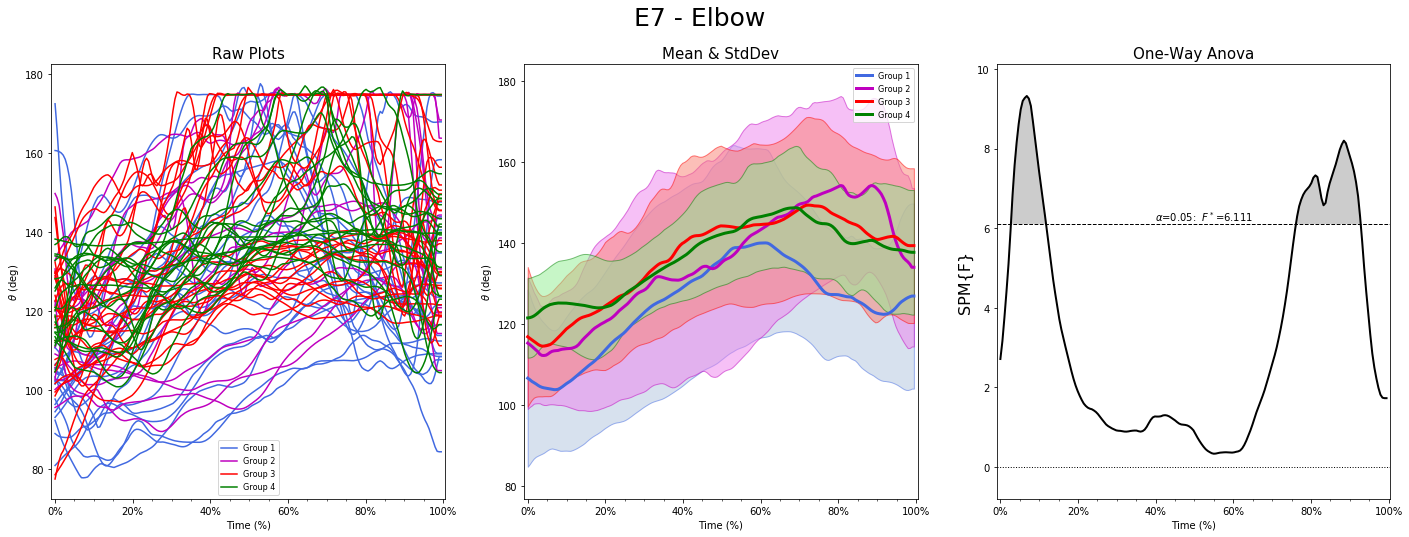

In [106]:
OneWay_Analysis(J[0][0],J[1][0])

C:\Users\KAGUMBA\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: 



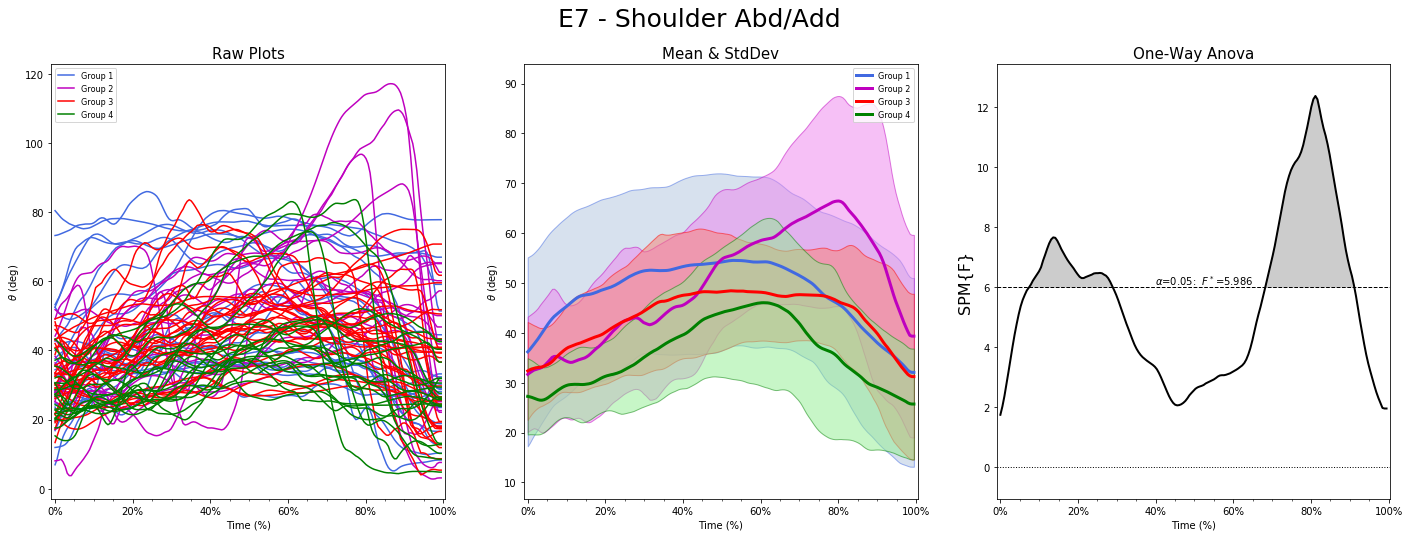

In [107]:
OneWay_Analysis(J[0][1],J[1][1])

C:\Users\KAGUMBA\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: 



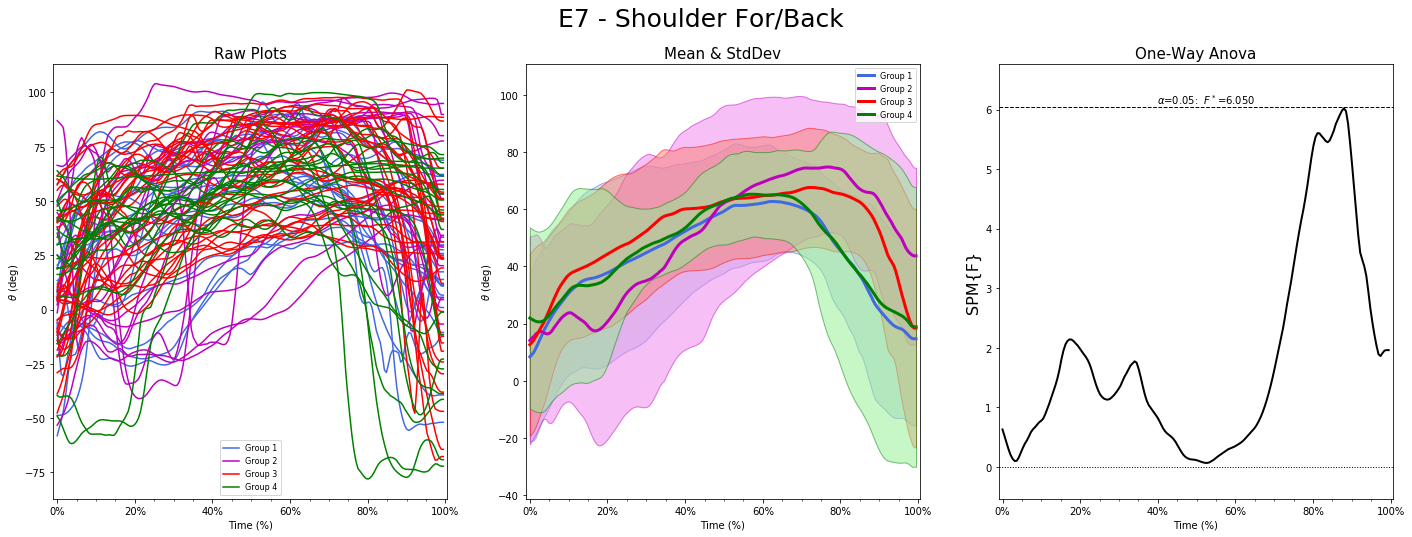

In [108]:
OneWay_Analysis(J[0][2],J[1][2])

C:\Users\KAGUMBA\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: 



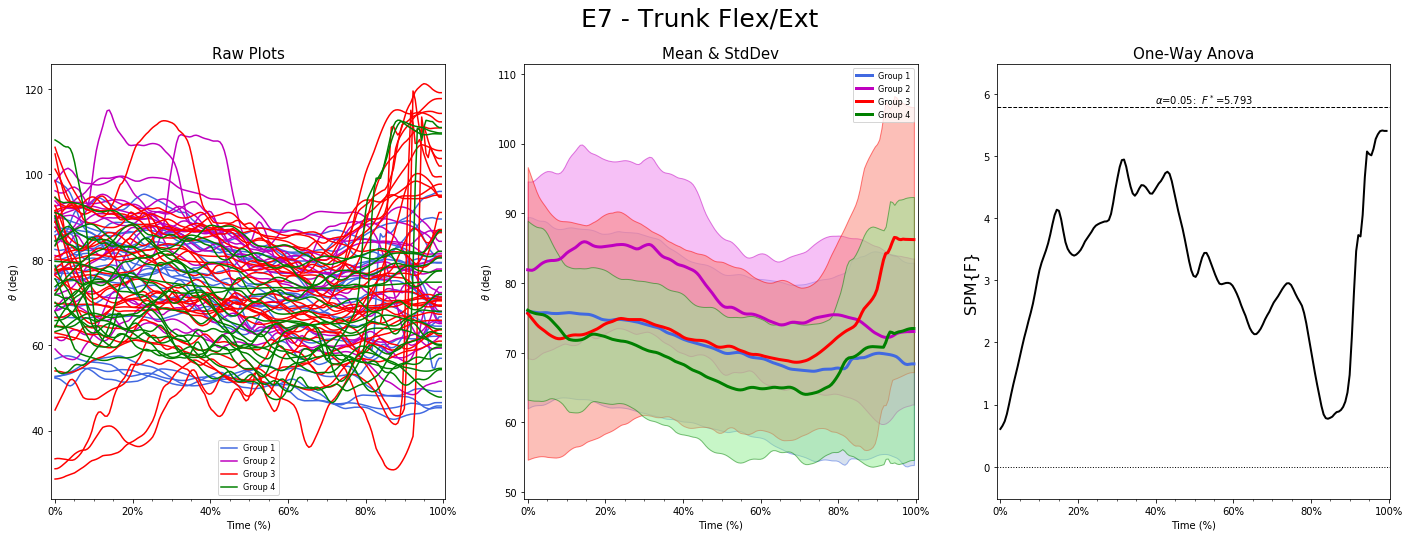

In [109]:
OneWay_Analysis(J[0][3],J[1][3])

C:\Users\KAGUMBA\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: 



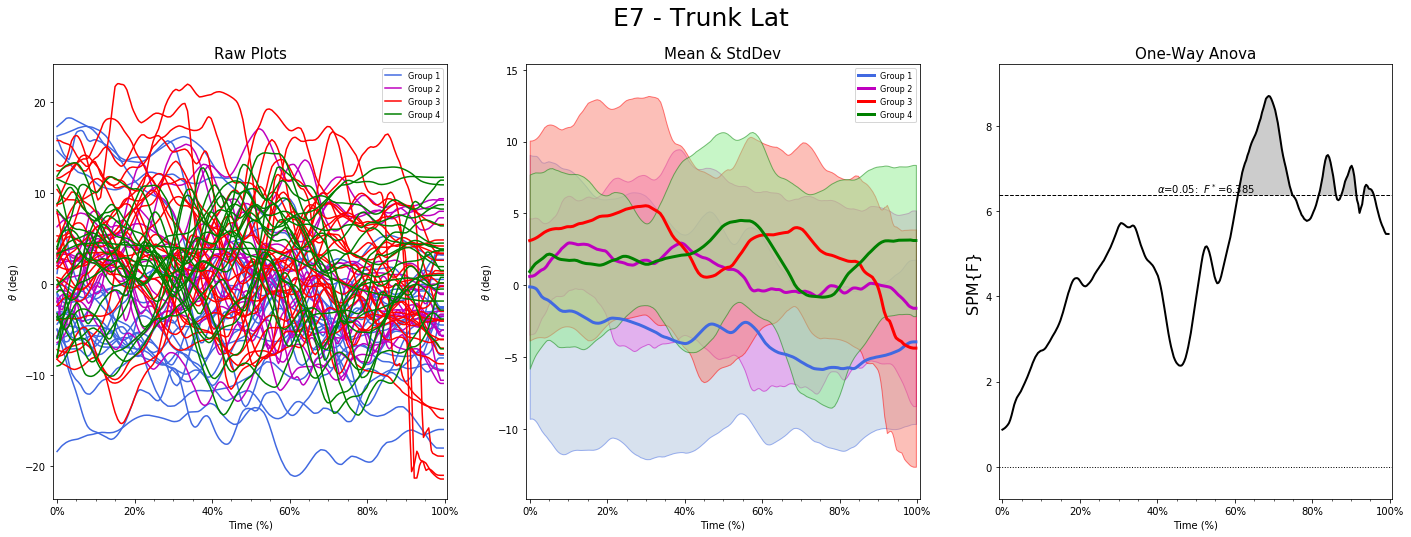

In [110]:
OneWay_Analysis(J[0][4],J[1][4])

C:\Users\KAGUMBA\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: 



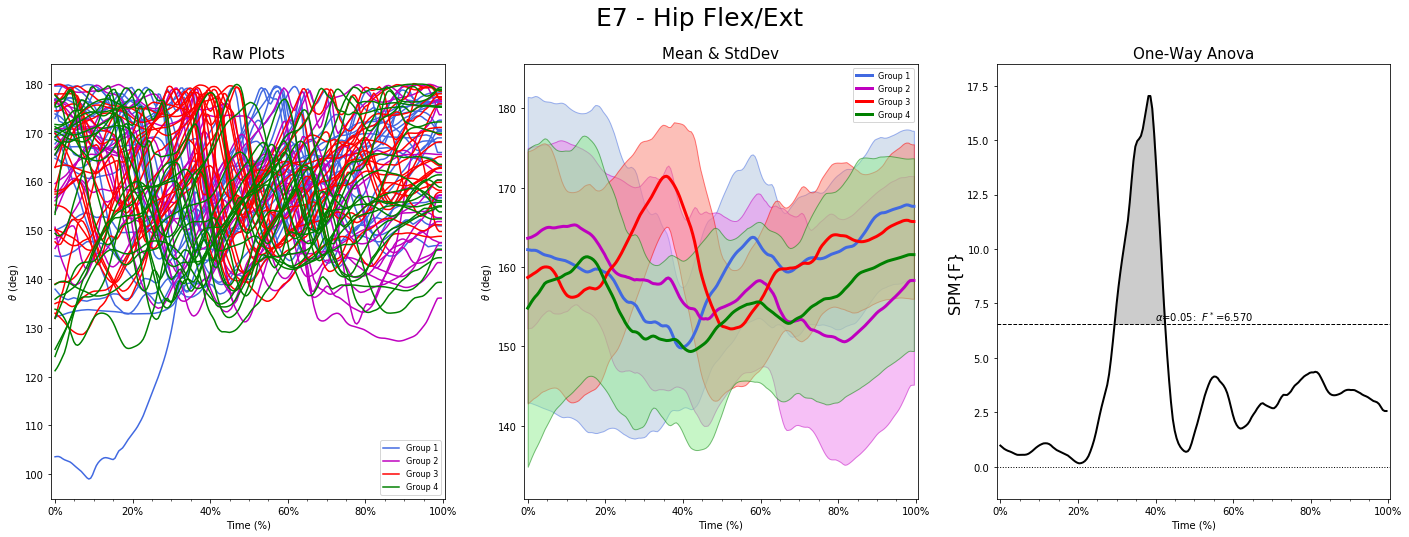

In [111]:
OneWay_Analysis(J[0][5],J[1][5])

C:\Users\KAGUMBA\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: 



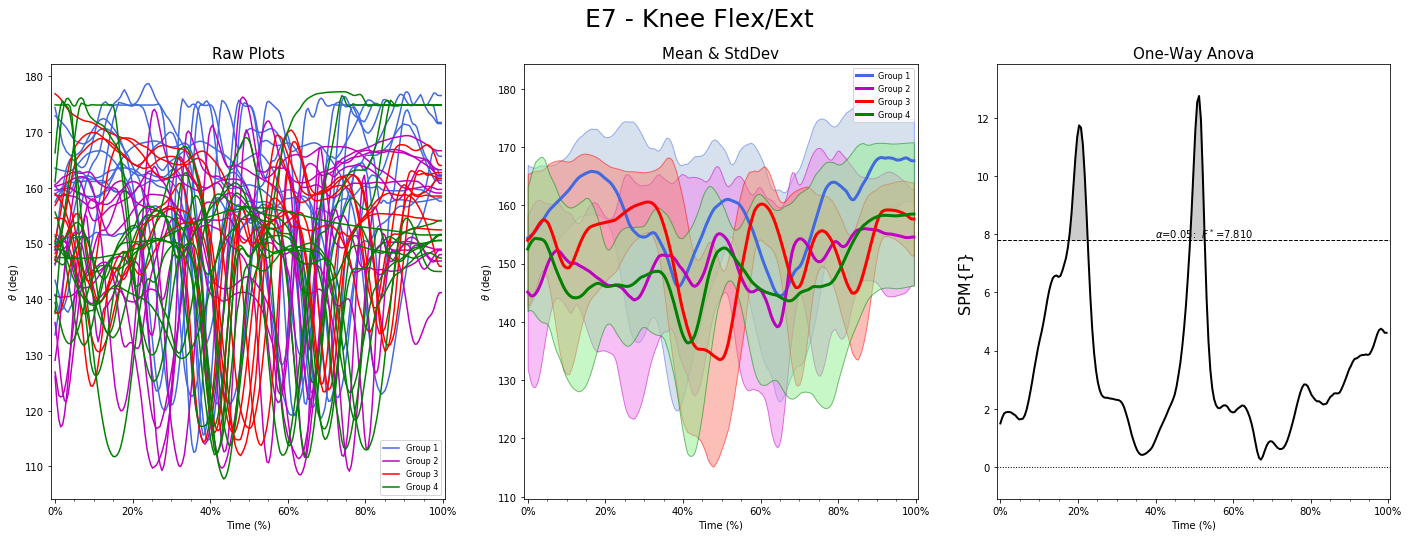

In [112]:
OneWay_Analysis(J[0][6],J[1][6])